In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from timeit import timeit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

2025-03-07 10:29:30.626030: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df_comp = pd.read_csv('/Users/federicovitro/Documents/2 - Areas/Portfolio/roundness_prediction_centerless_grinding/CenterlessGrindingDataPreprocessed.csv')
df_comp = df_comp.drop(['Unnamed: 0'], axis=1)
df_comp.head()

,wp_height,blade_angle,feed_vel,tot_diam_remov,wp_lenght,wp_diameter,grind_wheel_diam,contr_wheel_diam,contr_wheel_vel,grind_spec_energy,edge_force_comp,grit_stiff,Hi_fidelity_output
0,0.381000,0.267226,1.515967,-0.540471,1.723171,-0.164494,-0.391149,0.814013,1.563328,1.431395,-0.747201,-0.023258,0.337581
1,-1.159070,0.267226,1.519350,-0.472901,1.645364,1.373885,-1.236877,-0.960324,0.638102,-0.693074,-0.856300,-0.132356,-0.151096
2,-1.617455,0.267226,-0.049475,-0.878322,0.453733,0.808093,1.410251,-0.041018,0.355629,1.119321,-1.492287,0.025795,-0.691365
3,0.645713,0.267226,-0.315034,-0.675612,-1.566711,1.424629,0.327720,-0.015646,-0.221158,0.677005,-1.077035,0.475722,-0.538889
4,-1.609843,0.267226,0.567061,-0.067479,-1.071114,0.352246,1.373885,-1.300307,1.189516,-0.879980,-1.406023,-1.060120,1.222961


In [3]:
df = df_comp.copy()
X = df.drop(['Hi_fidelity_output'], axis=1)
y = df['Hi_fidelity_output']

In [4]:
seed = 1307274018

In [5]:
n_folds = 10
cv_folds = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

In [6]:
columns_trans = ColumnTransformer(
    transformers=[
        ('polynomial', PolynomialFeatures(degree=2, include_bias=False), X.columns)
    ]
)

In [7]:
def get_models():
    models = dict()

    models['Linear'] = Pipeline(steps=[('pre', columns_trans), ('m', LinearRegression())])
    models['Lasso'] = Pipeline(steps=[('pre', columns_trans), ('m', Lasso(alpha=0.1, random_state=seed))])
    models['Ridge'] = Pipeline(steps=[('pre', columns_trans), ('m', Ridge(alpha=0.1, random_state=seed))])
    models['KNN'] = Pipeline(steps=[('pre', columns_trans), ('m', KNeighborsRegressor(n_neighbors=5))])
    models['CART'] = Pipeline(steps=[('pre', columns_trans), ('m', DecisionTreeRegressor(random_state=seed))])
    models['RF'] = Pipeline(steps=[('pre', columns_trans), ('m', RandomForestRegressor(n_estimators=100, random_state=seed))])
    models['AB'] = Pipeline(steps=[('pre', columns_trans), ('m', AdaBoostRegressor(n_estimators=100, random_state=seed))])
    models['GBM'] = Pipeline(steps=[('pre', columns_trans), ('m', GradientBoostingRegressor(n_estimators=100, random_state=seed))])
    models['XGB'] = Pipeline(steps=[('Pre', columns_trans), ('m', XGBRegressor(n_estimators=100, random_state=seed))])
    models['SVR'] = Pipeline(steps=[('Pre', columns_trans), ('m', SVR())])
    models['HGB'] = Pipeline(steps=[('Pre', columns_trans), ('m', HistGradientBoostingRegressor(random_state=seed))])
    models['MLP'] = Pipeline(steps=[('Pre', columns_trans), ('m', MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', max_iter=200, random_state=seed))])

    return models

In [8]:
def evaluate_model(model, X, y):
#    scores = - cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv_folds, n_jobs=-1)
    scores = cross_val_score(model, X, y, scoring='r2', cv=cv_folds, n_jobs=-1)
    return scores

In [9]:
models = get_models()

results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)

In [10]:
scores_df = pd.DataFrame(results, index=names).T
display(scores_df)

,Linear,Lasso,Ridge,KNN,CART,RF,AB,GBM,XGB,SVR,HGB,MLP
0,0.191429,0.085145,0.191417,0.075172,-0.087308,0.294772,-0.078319,0.257102,0.246757,0.116110,0.238084,0.176581
1,0.375092,0.250723,0.375130,0.218229,-0.790437,0.508006,-0.855730,0.536300,0.528113,0.441577,0.534374,-0.067511
2,0.305332,0.213486,0.305327,0.040911,0.132852,0.431268,-0.653359,0.410656,-0.595772,0.393820,0.459582,-1.202265
3,0.472389,0.243317,0.472392,0.275979,-0.074668,0.562872,-0.596695,0.552133,0.515051,0.453968,0.582297,0.157261
4,0.337764,0.122230,0.337742,0.188223,0.125251,0.455611,-0.231708,0.462799,0.495861,0.296057,0.528930,0.128352
5,0.354738,0.220917,0.354769,0.150007,-0.249563,0.506711,-0.824530,0.462901,0.238321,0.388566,0.481232,0.096964
6,0.245157,0.215389,0.245189,-0.076967,-0.110170,0.327514,-1.228702,0.384843,0.534100,0.318396,0.457660,0.045691
7,0.385310,0.179346,0.385320,0.221955,-0.256909,0.491414,-0.461061,0.390733,0.321042,0.411198,0.530907,0.142507
8,0.404431,0.210782,0.404425,0.216338,-0.464541,0.501586,-0.148694,0.579027,0.488534,0.383395,0.539124,0.135175
9,0.410003,0.245430,0.410018,0.170515,-0.391485,0.506941,-0.521906,0.518276,-0.022507,0.392315,0.615090,0.107397


In [11]:
scores_df.describe()

,Linear,Lasso,Ridge,KNN,CART,RF,AB,GBM,XGB,SVR,HGB,MLP
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.348165,0.198676,0.348173,0.148036,-0.216698,0.458670,-0.560070,0.455477,0.274950,0.359540,0.496728,-0.027985
std,0.082791,0.054908,0.082793,0.105915,0.281114,0.085420,0.355100,0.097601,0.354999,0.098295,0.103706,0.418484
min,0.191429,0.085145,0.191417,-0.076967,-0.790437,0.294772,-1.228702,0.257102,-0.595772,0.116110,0.238084,-1.202265
25%,0.313440,0.187205,0.313431,0.093880,-0.357841,0.437354,-0.781737,0.395714,0.240430,0.334646,0.464995,0.058509
50%,0.364915,0.214437,0.364949,0.179369,-0.179867,0.496500,-0.559300,0.462850,0.404788,0.390441,0.529919,0.117874
75%,0.399651,0.237717,0.399649,0.217756,-0.077828,0.506884,-0.289046,0.531794,0.510254,0.406853,0.537936,0.140674
max,0.472389,0.250723,0.472392,0.275979,0.132852,0.562872,-0.078319,0.579027,0.534100,0.453968,0.615090,0.176581


In [14]:
#performances = pd.DataFrame(scores_df.mean(), columns=['RMSE'])
performances = pd.DataFrame(scores_df.mean(), columns=['R2'])
performances['std'] = scores_df.std()
#performances = performances.sort_values(by='RMSE', ascending=True)
performances = performances.sort_values(by='R2', ascending=False)
performances

,R2,std
HGB,0.496728,0.103706
RF,0.458670,0.085420
GBM,0.455477,0.097601
SVR,0.359540,0.098295
Ridge,0.348173,0.082793
Linear,0.348165,0.082791
XGB,0.274950,0.354999
Lasso,0.198676,0.054908
KNN,0.148036,0.105915
MLP,-0.027985,0.418484


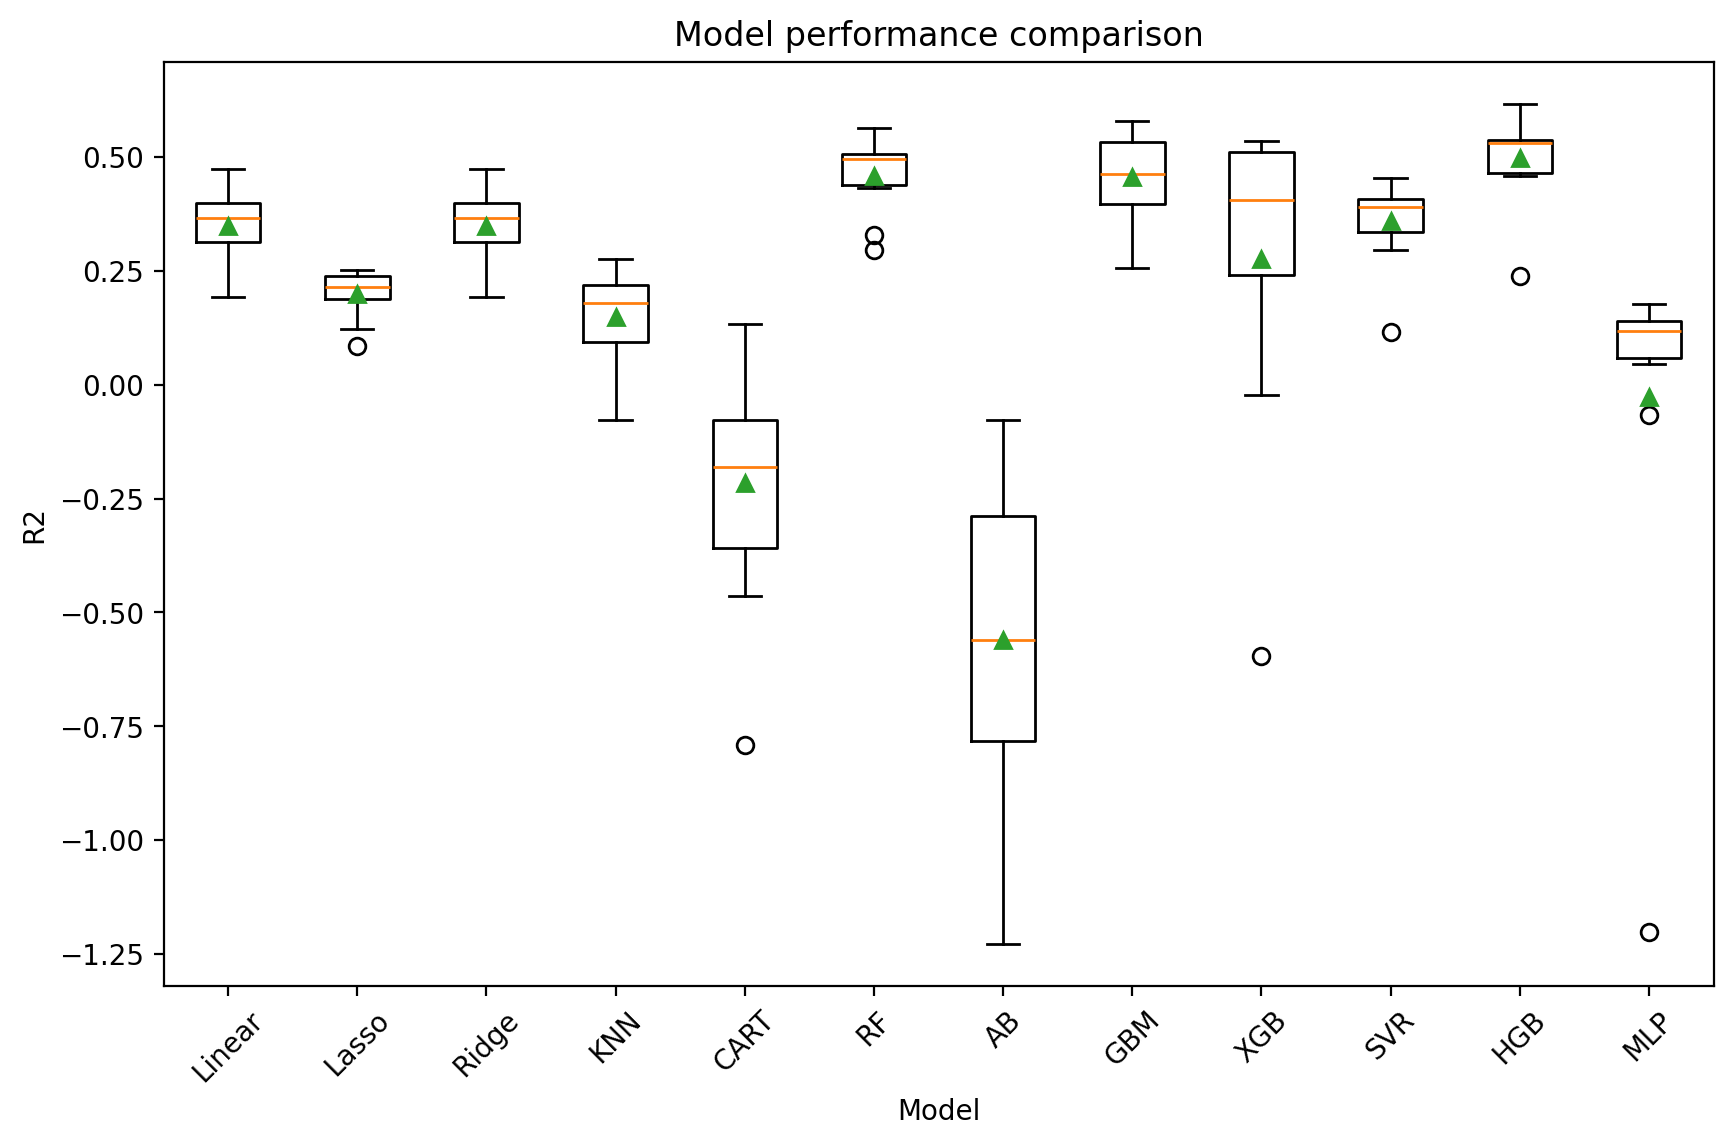

In [13]:
plt.figure(figsize=(10, 6))
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=45)
plt.xlabel('Model')
#plt.ylabel('RMSE')
plt.ylabel('R2')
plt.title('Model performance comparison')
plt.show()